# Import libraries and set global variables

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import pandas as pd
import numpy as np
from utils import *
from gages_utils import load_gages_dataset
from find_optimal_dimension import wrapper as optimal_dimension
import matplotlib.pyplot as plt
import json
import os.path
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import spearmanr, shapiro

#import seaborn as sns

NOT_FOR_SIM = ['STAID', 'HUC02','LAT_GAGE','LNG_GAGE','STATE', 'CLASS']

make_similarity = make_cosine_similarity

%matplotlib inline
#sns.set()

/home/fciulla/.local/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Load GAGES II dataset

In [2]:
df, cols_for_similarity = load_gages_dataset(do_process_raw_columns=True)

Rund the next cell only if you want to select a subset of the stations based on HUC and perform the entire analysis only with those data points

In [3]:
df = df[df["HUC02"]=='14']
df

STAID  DRAIN_SQKM HUC02   LAT_GAGE    LNG_GAGE STATE    CLASS  \
6591         09010500       163.0    14  40.325818 -105.856679    CO  Non-ref   
6592         09011000       263.8    14  40.218874 -105.857513    CO  Non-ref   
6593         09016500       124.3    14  40.112486 -105.749730    CO  Non-ref   
6594         09019000       802.1    14  40.144152 -105.867235    CO  Non-ref   
6595         09019500       835.7    14  40.120819 -105.900569    CO  Non-ref   
...               ...         ...   ...        ...         ...   ...      ...   
6954         09381800      1682.6    14  37.107484 -111.906010    UT  Non-ref   
6955         09382000      3677.9    14  36.872210 -111.594605    AZ  Non-ref   
9058  385106106571000       187.4    14  38.851659 -106.953377    CO  Non-ref   
9059  392547106023400        54.2    14  39.429722 -106.042778    CO  Non-ref   
9061  394220106431500      1571.9    14  39.705000 -106.725833    CO  Non-ref   

      HYDRO_DISTURB_INDX  BAS_COMPACTNESS  PPTAVG_BASIN  ...  \
6591                  10             2.75         88.35  ...   
6592                  10             2.06         80.86  ...   
6593                   4             2.61         91.67  ...   
6594                  14             1.69         79.65  ...   
6595                  15             1.64         78.13  ...   
...                  ...              ...           ...  ...   
6954                   4             1.66         31.01  ...   
6955                   4             1.46         30.49  ...   
9058                  16             2.84         84.13  ...   
9059                  20             3.05         79.89  ...   
9061                  23             1.51         63.06  ...   

      ELEV_MIN_M_BASIN  ELEV_MEDIAN_M_BASIN  ELEV_STD_M_BASIN  ELEV_SITE_M  \
6591              2671                 3233             266.5         2672   
6592              2553                 3122             300.9         2555   
6593              2539                 3257             301.9         2545   
6594              2462                 3098             352.4         2469   
6595              2426                 3073             358.5         2426   
...                ...                  ...               ...          ...   
6954              1329                 1909             267.4         1329   
6955               957                 1878             258.5          993   
9058              2688                 3122             259.7         2693   
9059              3058                 3580             268.5         3058   
9061              2089                 3071             417.9         2097   

      RRMEAN  RRMEDIAN  SLOPE_PCT  ASPECT_DEGREES  ASPECT_NORTHNESS  \
6591   0.430     0.447       31.7           137.9            -0.742   
6592   0.406     0.414       26.9           145.9            -0.828   
6593   0.445     0.455       42.7           292.9             0.389   
6594   0.375     0.385       29.6           216.7            -0.802   
6595   0.377     0.383       29.0           220.6            -0.759   
...      ...       ...        ...             ...               ...   
6954   0.334     0.321       17.0           150.3            -0.868   
6955   0.421     0.423       13.4            45.4             0.703   
9058   0.335     0.329       31.4           152.7            -0.888   
9059   0.429     0.412       35.5            41.6             0.747   
9061   0.439     0.457       29.6           359.8             1.000   

      ASPECT_EASTNESS  
6591            0.671  
6592            0.560  
6593           -0.921  
6594           -0.597  
6595           -0.651  
...               ...  
6954            0.496  
6955            0.712  
9058            0.459  
9059            0.664  
9061           -0.004  

[368 rows x 282 columns]

# Remove zero variance variables

In [4]:

df_cols_for_similarity = df[cols_for_similarity]
df_std = np.std(df_cols_for_similarity.values, axis=0)
zero_std_cols = df_cols_for_similarity.columns.values[(np.isnan(df_std)) | (df_std==0)]
df.drop(columns=zero_std_cols, inplace=True)
df_cols_for_similarity.drop(columns=zero_std_cols, inplace=True)
cols_for_similarity=[x for x in cols_for_similarity if x not in zero_std_cols]
df

/tmp/ipykernel_8410/1785331014.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cols_for_similarity.drop(columns=zero_std_cols, inplace=True)


STAID  DRAIN_SQKM HUC02   LAT_GAGE    LNG_GAGE STATE    CLASS  \
6591         09010500       163.0    14  40.325818 -105.856679    CO  Non-ref   
6592         09011000       263.8    14  40.218874 -105.857513    CO  Non-ref   
6593         09016500       124.3    14  40.112486 -105.749730    CO  Non-ref   
6594         09019000       802.1    14  40.144152 -105.867235    CO  Non-ref   
6595         09019500       835.7    14  40.120819 -105.900569    CO  Non-ref   
...               ...         ...   ...        ...         ...   ...      ...   
6954         09381800      1682.6    14  37.107484 -111.906010    UT  Non-ref   
6955         09382000      3677.9    14  36.872210 -111.594605    AZ  Non-ref   
9058  385106106571000       187.4    14  38.851659 -106.953377    CO  Non-ref   
9059  392547106023400        54.2    14  39.429722 -106.042778    CO  Non-ref   
9061  394220106431500      1571.9    14  39.705000 -106.725833    CO  Non-ref   

      HYDRO_DISTURB_INDX  BAS_COMPACTNESS  PPTAVG_BASIN  ...  \
6591                  10             2.75         88.35  ...   
6592                  10             2.06         80.86  ...   
6593                   4             2.61         91.67  ...   
6594                  14             1.69         79.65  ...   
6595                  15             1.64         78.13  ...   
...                  ...              ...           ...  ...   
6954                   4             1.66         31.01  ...   
6955                   4             1.46         30.49  ...   
9058                  16             2.84         84.13  ...   
9059                  20             3.05         79.89  ...   
9061                  23             1.51         63.06  ...   

      ELEV_MIN_M_BASIN  ELEV_MEDIAN_M_BASIN  ELEV_STD_M_BASIN  ELEV_SITE_M  \
6591              2671                 3233             266.5         2672   
6592              2553                 3122             300.9         2555   
6593              2539                 3257             301.9         2545   
6594              2462                 3098             352.4         2469   
6595              2426                 3073             358.5         2426   
...                ...                  ...               ...          ...   
6954              1329                 1909             267.4         1329   
6955               957                 1878             258.5          993   
9058              2688                 3122             259.7         2693   
9059              3058                 3580             268.5         3058   
9061              2089                 3071             417.9         2097   

      RRMEAN  RRMEDIAN  SLOPE_PCT  ASPECT_DEGREES  ASPECT_NORTHNESS  \
6591   0.430     0.447       31.7           137.9            -0.742   
6592   0.406     0.414       26.9           145.9            -0.828   
6593   0.445     0.455       42.7           292.9             0.389   
6594   0.375     0.385       29.6           216.7            -0.802   
6595   0.377     0.383       29.0           220.6            -0.759   
...      ...       ...        ...             ...               ...   
6954   0.334     0.321       17.0           150.3            -0.868   
6955   0.421     0.423       13.4            45.4             0.703   
9058   0.335     0.329       31.4           152.7            -0.888   
9059   0.429     0.412       35.5            41.6             0.747   
9061   0.439     0.457       29.6           359.8             1.000   

      ASPECT_EASTNESS  
6591            0.671  
6592            0.560  
6593           -0.921  
6594           -0.597  
6595           -0.651  
...               ...  
6954            0.496  
6955            0.712  
9058            0.459  
9059            0.664  
9061           -0.004  

[368 rows x 271 columns]

# Correlation analysis

In [ ]:
    # none is normally distributed
    shapiro_test = [shapiro(df_cols_for_similarity[col].values)[1]>0.05 for col in df_cols_for_similarity.columns]
    #print(shapiro_test)
    normality_ratio = np.sum(shapiro_test)/len(df_cols_for_similarity.columns)
    print(normality_ratio)
    
    sp_r, sp_p = spearmanr(df_cols_for_similarity.values)
    print(np.sum(sp_p[np.triu_indices(sp_p.shape[0], k=1)]<0.05)/(sp_p.shape[0]*(sp_p.shape[0]-1)/2.)) # 0.91
    sp_r, sp_p = corrcoef(df_cols_for_similarity.values)
    print(np.sum(sp_p[np.triu_indices(sp_p.shape[0], k=1)]<0.05)/(sp_p.shape[0]*(sp_p.shape[0]-1)/2.)) # 0.89

    df_spear = df_cols_for_similarity.corr(method="spearman")
    sns.heatmap(df_spear, cmap='viridis', annot=False)
    plt.savefig("heatmap_spearman")
    plt.close()
    M_spear = df_spear.values
    sp = M_spear[np.triu_indices(M_spear.shape[0], k=1)]
    print({i: 100*np.sum(np.abs(sp)>i)/len(sp) for i in [0.0, 0.3, 0.5, 0.7, 0.9]})
    #{0.2: 42.518911745189115, 0.5: 8.31320504313205, 0.7: 3.323158593231586, 0.9: 1.0218978102189782}
    df_pear = df_cols_for_similarity.corr(method="pearson")
    sns.heatmap(df_pear,  cmap='viridis', annot=False)
    plt.savefig("heatmap_pearson")
    plt.close()
    M_pear = df_pear.values
    p = M_pear[np.triu_indices(M_pear.shape[0], k=1)]
    print({i: 100*np.sum(np.abs(p)>i)/len(p) for i in [0.0, 0.3, 0.5, 0.7, 0.9]})
    #{0.2: 23.644326476443265, 0.5: 5.656270736562707, 0.7: 2.8931652289316525, 0.9: 0.9236894492368944}
    plot_distribution([p,sp], ['pearson', 'spearman'], [31,31], suffix_filename='correlations')



# Standardize dataset and create matrix

In [5]:
df_standardized = standardize_df(df_cols_for_similarity)
M = df_standardized.values
print(M.shape)


(368, 265)


/home/fciulla/coding/catchments/../utils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.columns] = standardize_M(df.values)


# PCA

In [6]:
U, S, VT = np.linalg.svd(M, full_matrices=True)
reconstruction_error = [np.sqrt(np.sum((M - U[:,:k].dot(np.diag(S[:k])).dot(VT[:k,:]))**2)) for k in np.arange(len(S))+1]
k=20
#k=16 #for HUC02=14
#k = optimal_dimension(U, S, VT, make_similarity)
print(k)

M_transf = U[:,:k].dot(np.diag(S[:k]))
PCs = VT[:k, :].T
M_reconstructed = U[:,:k].dot(np.diag(np.array(S[:k]))).dot(VT[:k,:])


16


# Make pairwise similarity
Because manhattan distance is slow to be computed, if present, the values are pulled from a previously saved file

In [7]:
if make_similarity==make_manhattan_similarity:
    if os.path.isfile('attr_similarity_manhattan_%d.npy' % k):
        with open('attr_similarity_manhattan_%d.npy' % k, 'rb') as f:
            attr_similarity = np.load(f)
        f.close()
    else:
        with open('attr_similarity_manhattan_%d.npy' % k, 'wb') as f:
            np.save(f, attr_similarity)
        f.close()
else:
    attr_similarity = make_similarity(PCs)

if make_similarity==make_manhattan_similarity:
    if os.path.isfile('gauges_similarity_manhattan_%d.npy' % k):
        with open('gauges_similarity_manhattan_%d.npy' % k, 'rb') as f:
            gauges_similarity = np.load(f)
        f.close()
    else:
        with open('gauges_similarity_manhattan_%d.npy' % k, 'wb') as f:
            np.save(f, gauges_similarity)
        f.close()
else:
    gauges_similarity = make_similarity(M_transf)


# Set backbone threshold
Run the next two cells only if you want to compute the values from scratch. Othrewise use the values in the thrid cell

In [ ]:
alpha_attr = make_backbone_wrapper(attr_similarity, np.logspace(-1,0,401), target=.95, suffix='attr', reciprocated=False)
print(alpha_attr) 

In [ ]:
alpha_gauges = make_backbone_wrapper(gauges_similarity, np.logspace(-1,0,201), target=.95, suffix='gauges', reciprocated=False)
print(alpha_gauges)

In [7]:

if make_similarity==make_manhattan_similarity:
    alpha_attr = {20:0.36}[k]
    alpha_gauges = {20:0.335}[k]
if make_similarity==make_cosine_similarity:
    alpha_attr = {12:0.18836490894898011, 20:0.21627185237270202, 40: 0.245}[k]
    alpha_gauges = {12:0.1548816618912481, 20:0.1548816618912481, 40:0.15848931924611134}[k]
    #alpha_gauges = {20:0.18}[k] #coarse 
    #alpha_gauges = {20:0.14621771744567183, 40:0.15}[k] #fine
    
if make_similarity==make_euclidean_similarity:
    alpha_attr = {20:0.234}[k]
    alpha_gauges = {20:0.335}[k]


# Generate traits network and clustering

In [10]:
G_V = make_backbone_network(attr_similarity, cols_for_similarity, alpha = alpha_attr, reciprocated=False)
print("attributes", len(G_V.nodes()), len(G_V.edges()))
_, communities_attr, communities_attr_to_nodes_dict = make_community(G_V, return_inv=True)

attributes 265 1090


This just prints the nodes per cluster for visual inspection

In [ ]:
for i,j in communities_attr_to_nodes_dict.items():
    print(i, [G_V.nodes[jj]["label"] for jj in j[:20]])

# Plot traits network

In [22]:
quantities = [{"name":"communities", "values":communities_attr, "discrete":True}]
plot_network(G_V, quantities, nodesize=None, suffix='attributes')

# Generate nodes sorted by degree centrality

Not needed for the general workflow

In [ ]:
nodes= sorted(nx.degree_centrality(G_V).items(), key=lambda item: item[1], reverse=True)
print(nodes)
nodes = [a[0] for a in nodes]
for i,j in communities_attr_to_nodes_dict.items():
    print(i)
    print(", ".join(sorted([nx.get_node_attributes(G_V, "label")[x].replace("_", "\_") for x in nodes if x in j]) ), len(j))


# Generate catchments network and clustering

In [12]:
gauges_id = df['STAID']
G = make_backbone_network(gauges_similarity, gauges_id, alpha = alpha_gauges, reciprocated=False)
print("gages", len(G.nodes()), len(G.edges()))
_, communities, communities_inv = make_community(G, return_inv=True)

gages 368 1931


# Generate giant component

In [13]:
nodes_id_giant_comp = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])
G_giant = G.subgraph(list(nx.connected_components(G))[0]).copy()
communities_giant = {i:communities[i] for i in nodes_id_giant_comp}

# Plot only giant component of catchments network

In [14]:
quantities = [{"name":"communities", "values":communities_giant, "discrete":True}]

plot_network(G_giant, quantities, nodesize=None, suffix='catchments_giant', do_plot_labels=False)

# Creates operational varibles for future use 

In [15]:
list_communities_attr = [[nx.get_node_attributes(G_V, "label")[i] for i in j] for _,j in communities_attr_to_nodes_dict.items()]
#for i,j in enumerate(list_communities_attr):
#    print(i+1, j)
dict_attribute_cluster = {}
dict_len_attribute_cluster = {}
for i,j in enumerate(list_communities_attr):
    dict_len_attribute_cluster[i] = len(j)
    for jj in j:
        dict_attribute_cluster[jj] = i
#print(dict_attribute_cluster)

# Add clusters to dataframe

In [16]:
gauges_to_nodes = {j:i for i,j in nx.get_node_attributes(G, "label").items()}
df["community"] = [communities[gauges_to_nodes[x]] for x in gauges_id]
community_counts_dict = df.community.value_counts().to_dict()

# Generate spatial coherence measure

0 3.7171505589451526 4.912525498741204
1 7.721220563257286 22.007344121739777
2 3.1557922102118856 4.102312164426005
3 3.7040172103169207 4.0213649246237475
4 2.303306356372326 5.635305304514589
5 2.0133207068733774 5.262880643886507
6 2.9251346581009217 7.859638947315556
7 1.1949839063797898 4.529142000914134
8 3.893029488041257 9.3360449301107
9 1.6236745681922182 2.9252699280436776
10 2.0394508089419743 3.419711746255032
11 2.492570333060212 4.267565942401584
12 1.4569786394337816 5.0218047700120385
13 4.322052683272099 6.933204815321713
14 3.3075227212522353 6.200919350248718
15 3.3635368750539967 4.509890932484987
16 1.4152109229245813 3.492960974100604
17 0.9778700202044115 5.65134107676528
18 4.212027822721001 6.287741081566087
19 1.0425223386818399 3.440293754428472
20 3.603884907369561 11.105387594941485
21 1.2420137923116552 4.156241961849882
22 0.9593800715942191 3.9512332620150543
23 1.1187963378854275 2.932618645431243
24 1.213274273313747 5.2537887973381725
25 0.996916897

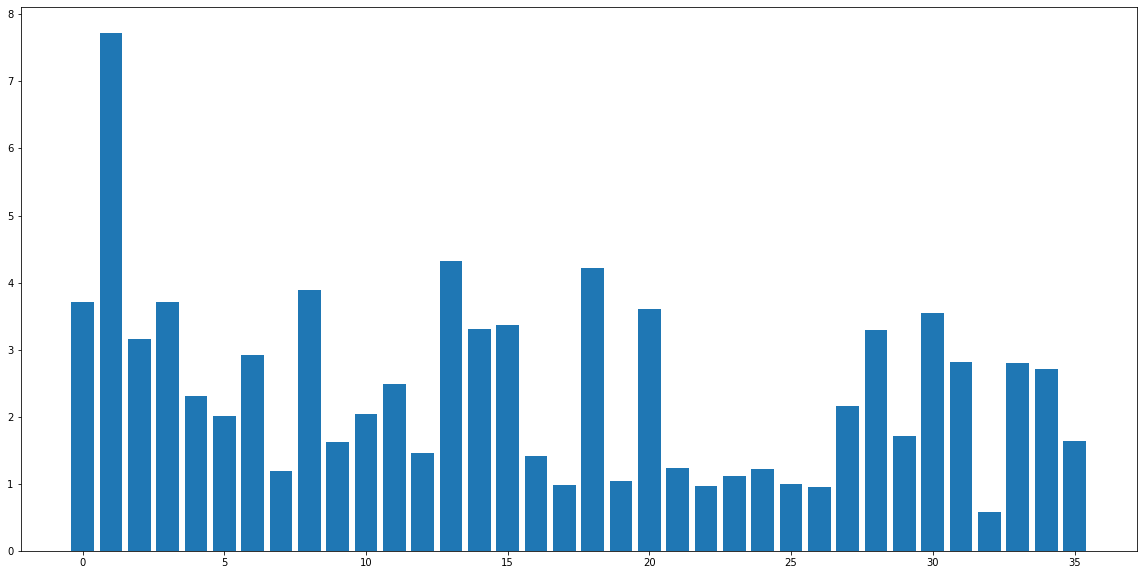

In [23]:
from scipy.spatial.distance import pdist, cdist
X=[]; Y=[]
for i in range(36):
    df_cluster = df[df['community']==i][["LAT_GAGE","LNG_GAGE"]]
    coords = df_cluster.values
    #plt.scatter(coords[:,1],coords[:,0],color='k')
    #print(df_cluster)
    centroid = coords.mean(axis=0)
    #print(centroid)
    d_from_centroid = np.sqrt(((coords-centroid)**2).sum(axis=1))
    coords = coords[d_from_centroid<=np.percentile(d_from_centroid, 95),:]
    centroid = coords.mean(axis=0)
    d_from_centroid = np.sqrt(((coords-centroid)**2).sum(axis=1))
    pairwise_distances = pdist(coords)
    #plt.scatter(coords[:,1],coords[:,0])
    nn_dists = cdist(coords, coords)
    nn_dists.sort()
    nn_dists = nn_dists[:,1]
    #nn_dists = nn_dists[:, np.maximum(5, int(0.01*len(nn_dists)))]
    #nn_dists = nn_dists[:, :int(0.01*len(nn_dists))].mean(axis=1)
    nn_dist_ave = np.mean(nn_dists)
    
    print(i, np.std(pairwise_distances), 2.*np.percentile(d_from_centroid, 100)/(np.sqrt(1.*len(nn_dists)-1)*nn_dist_ave))
    X.append(np.std(pairwise_distances))
    Y.append(2.*np.percentile(d_from_centroid, 100)/(np.sqrt(1.*len(nn_dists)-1)*nn_dist_ave))

    """"
    #print(centroid)
    coords_rad = np.deg2rad(df_cluster.values)
    #print(coords_rad)
    centroid_rad = np.deg2rad(centroid)
    #print(centroid_rad)
    
    diff_coords = coords_rad - centroid_rad
    #print(diff_coords)
    d = np.sin(diff_coords[:,0] / 2)**2 + np.cos(centroid_rad[0]) * np.cos(coords_rad[:,0]) * np.sin(diff_coords[:,1] / 2)**2
    d = 6370 * 2 * np.arcsin(np.sqrt(d))
    print(i, np.sqrt(np.sum(d**2)/len(d)))
    """
#plt.scatter(X,Y)
#plt.bar(np.arange(len(Y)), Y, alpha=0.5)
fig, ax = plt.subplots(figsize=(20,10), facecolor=(1, 1, 1))

ax.bar(np.arange(len(X)), X, alpha=1.)
plt.savefig("geo_coherence")
plt.show()


# Add state variable to dataframe

In [ ]:
community_to_states = df.groupby('community')['STATE'].agg([list]).to_dict()['list']
community_to_states = {i:Counter(j).most_common(5) for i,j in community_to_states.items()}

# Generate clusters anomalous expression

In [17]:
df_community_anomalies = make_df_community_anomalies(df[[x for x in df.columns.values if x not in NOT_FOR_SIM]])

# Plot traits anomalies in barchart 

In [20]:
plot_anomalies_agg(df_community_anomalies.loc[df["community"].value_counts().index.values,:],
                   dict_attribute_cluster, dict_len_attribute_cluster, community_counts_dict, community_to_states=community_to_states, min_community_size=50)
#plot_anomalies_agg(df_community_anomalies.loc[df.loc[df["HUC02"].isin(["14"])]["community"].value_counts().index.values,:],
#                   dict_attribute_cluster, dict_len_attribute_cluster, community_counts_dict, community_to_states=community_to_states, min_community_size=10, suffix='HUC02')

community: 0	num gauges: 932	color: [0.12156863 0.46666667 0.70588235]
[ -3.77  -3.28 -12.77  -5.73  -1.03  -1.05  -0.65  14.8   10.54  -4.17
  -2.26   0.03  -5.68  -1.98  -6.19  -1.63  -3.4    4.5    0.43   2.97
   2.38  -2.21   6.22  -1.48  -0.84]
community: 1	num gauges: 703	color: [1.         0.49803922 0.05490196]
[26.1   0.03  4.76 -3.16  0.63 -0.6  -1.54 -7.22 -6.71  0.04 -1.99 -3.41
  3.16 -3.28  4.48 -2.36 -2.65 -2.63 -0.79 -6.16  3.57 -6.13  5.61  0.2
  2.78]
community: 2	num gauges: 649	color: [0.17254902 0.62745098 0.17254902]
[ -1.32  -2.17  -1.48  15.75   1.68  -0.33  -2.06  -4.87  -7.42   0.25
  -2.11  -2.2    7.18  -0.84   3.9    0.21  -2.62  -5.6   -0.7   -5.92
   1.34   1.72 -21.27   0.26   6.81]
community: 3	num gauges: 469	color: [0.83921569 0.15294118 0.15686275]
[-3.440e+00 -7.220e+00 -8.570e+00 -3.610e+00  8.800e-01 -1.000e-02
 -3.220e+00  1.169e+01 -1.840e+00 -3.390e+00 -2.050e+00  9.000e-01
 -1.850e+00  3.050e+00 -1.018e+01  1.510e+00 -4.210e+00  2.220e+00
 -3.

community: 33	num gauges: 54	color: [0.77254902 0.69019608 0.83529412]
[-3.44  3.09 10.28 -2.23 -1.45 -1.22  2.04 -5.95  6.87 -2.13 -1.68 -2.64
  1.14 -0.66  7.34 -3.9  17.57 -3.73 -0.74 -4.7  -2.46  0.83  6.59  0.19
  7.13]
community: 35	num gauges: 52	color: [0.76862745 0.61176471 0.58039216]
[ -1.36   1.9    7.59   7.07   7.8   -0.85  -1.68  -5.74  -4.89   8.43
  -1.03  -0.86   9.19   0.68   3.52  -2.12  -2.56  -6.29  -0.5   -3.72
  -3.62   2.07 -12.46   0.31   3.77]


# Plot traits anomalies differences between two clusters

In [ ]:
plot_anomalies_agg_diff(df_community_anomalies.loc[df["community"].value_counts().index.values,:],
                   [0,22], dict_attribute_cluster, dict_len_attribute_cluster, community_counts_dict, community_to_states=community_to_states, min_community_size=40, suffix='diff')
#plot_anomalies_agg_diff(df_community_anomalies.loc[df.loc[df["HUC02"].isin(["14"])]["community"].value_counts().index.values,:],
#                   [8,9], dict_attribute_cluster, dict_len_attribute_cluster, community_counts_dict, community_to_states=community_to_states, min_community_size=10, suffix='HUC02_ave')

In [ ]:
plot_anomalies_agg_diff(df_community_anomalies.loc[df["community"].value_counts().index.values,:],
                   [0,22], dict_attribute_cluster, dict_len_attribute_cluster, community_counts_dict, community_to_states=community_to_states, min_community_size=40, suffix='diff')
#plot_anomalies_agg_diff(df_community_anomalies.loc[df.loc[df["HUC02"].isin(["14"])]["community"].value_counts().index.values,:],
#                   [8,9], dict_attribute_cluster, dict_len_attribute_cluster, community_counts_dict, community_to_states=community_to_states, min_community_size=10, suffix='HUC02_ave')

Visual inspection of number of nodes in communities

In [25]:
df.loc[df['HUC02'].isin(["14"])]["community"].value_counts()

0     49
1     48
2     25
3     18
4     17
5     16
7     15
6     15
9     14
8     14
11    13
10    13
12    11
14    10
13    10
15     9
16     8
17     7
19     6
18     6
21     5
20     5
23     4
22     4
24     4
25     3
28     2
26     2
27     2
39     1
35     1
38     1
40     1
33     1
36     1
30     1
34     1
32     1
31     1
29     1
41     1
37     1
Name: community, dtype: int64

# Plot gaging stations in map
There are different flavors to plot the map

In [ ]:
df.loc[df["HUC02"].isin(["14"])]["community"].value_counts()

In [18]:
#for i in range(36):
#    plot_gauges_in_map_dots(df.loc[df['community']==i], lat_col='LAT_GAGE', lon_col='LNG_GAGE', column='community', suffix=str(i))
#plot_gauges_in_map_dots(df.loc[df['community'].isin([0,22])], lat_col='LAT_GAGE', lon_col='LNG_GAGE', column='community', suffix='0_22')
plot_gauges_in_map_dots(df.loc[df['HUC02'].isin(["14"])], lat_col='LAT_GAGE', lon_col='LNG_GAGE', column='community', filename='datasets/HUC14_shapefiles/Shape/WBDHU2.shp', in_conus=False, suffix='HUC02_14')
#plot_gauges_in_map_dots(df, lat_col='LAT_GAGE', lon_col='LNG_GAGE', column='community', in_conus=True)
#plot_gauges_in_map_dots(df.loc[df['community'].isin(df.loc[df["HUC02"].isin(["14"])]["community"].value_counts().index.values)], lat_col='LAT_GAGE', lon_col='LNG_GAGE', column='community', filename='datasets/HUC14_shapefiles/Shape/WBDHU2.shp')



# Plot anomalies in network of traits
Network visualization of traits anomalies

In [ ]:
for community in [i for i,j in community_counts_dict.items() if j>=40]:
    print(community, df_community_anomalies.loc[community, :].values)
    plot_network(G_V,
        [{"name":"z-score", "values":dict(enumerate(df_community_anomalies.loc[community, :].values)), "discrete":False}],
        suffix='anomalies_%d_cluster'%community,
        bicolor=True, nodesize=dict(enumerate(np.abs(df_community_anomalies.loc[community, :].values))))


# Just print for latex
Not needed for workflow

In [ ]:
n=8
l = ['DEVNLCD06', 'NOV_PPT7100_CM', 'FEB_TMP7100_DEGC', 'RIP800_PLANT', 'PESTAPP_KG_SQKM', 'RIP800_41', 'LST32F_BASIN', 'RIP100_FOREST', 'GRASSNLCD06', 'SILTAVE', 'JUN_PPT7100_CM', 'MIXEDFORNLCD06', 'SANDAVE', 'SHRUBNLCD06', 'CDL_ALL_OTHER_LAND', 'ARTIFPATH_MAINSTEM_PCT', 'TOPWET', 'PASTURENLCD06', 'PADCAT1_PCT_BASIN', 'WD_SITE', 'DEVMEDNLCD06', 'STOR_NID_2009']
c = [l[i:i + n] for i in range(0, len(l), n)]
print(c)
for i in range(len(c[0])):
    
    a = []
    for j in range(len(c)):
        try:
            b = c[j][i].replace("_", "\_")
        except:
            b = ''
        a.append(b)
    print(" & ".join(a)+" \\\\")

# Random Forest features importance
First step needed for both the cluster-informed random forest and the regular random forest

349
349
['JUL_TMP7100_DEGC', 'OCT_PPT7100_CM', 'RH_BASIN', 'AUG_TMP7100_DEGC', 'SNOWICENLCD06', 'PERMAVE', 'T_AVG_BASIN', 'RIP100_42', 'SEP_PPT7100_CM', 'SEP_TMP7100_DEGC', 'JUN_TMP7100_DEGC', 'WD_BASIN', 'RIP800_12', 'SHRUBNLCD06', 'T_MAX_BASIN', 'APR_TMP7100_DEGC', 'MAINS800_DEV', 'T_MIN_BASIN', 'DEC_PPT7100_CM', 'DRAIN_SQKM', 'CONTACT', 'GRASSNLCD06', 'MAINS800_42', 'WTDEPAVE', 'MAINS800_12', 'SNOW_PCT_PRECIP', 'NOV_TMP7100_DEGC', 'PASTURENLCD06', 'JUL_PPT7100_CM', 'RIP800_71', 'WB5100_MAY_MM', 'DEC_TMP7100_DEGC', 'MAR_PPT7100_CM', 'AUG_PPT7100_CM', 'MAR_TMP7100_DEGC', 'MAY_TMP7100_DEGC', 'FEB_PPT7100_CM', 'PERHOR', 'NITR_APP_KG_SQKM', 'WB5100_JUN_MM', 'RIP800_41', 'MAINS100_DEV', 'RIP100_41', 'NDAMS_2009', 'RIP800_PLANT', 'RIP100_81', 'IMPNLCD06', 'RIP800_42', 'JAN_TMP7100_DEGC', 'RIP100_90', 'RIP800_52', 'MAY_PPT7100_CM', 'FRESHW_WITHDRAWAL', 'OCT_TMP7100_DEGC', 'MAINS800_41', 'RIP100_95', 'MAINS100_23', 'RIP800_81', 'ELEV_MEDIAN_M_BASIN', 'FST32F_BASIN', 'PDEN_2000_BLOCK', 'PLANT

ValueError: vmin, vcenter, and vmax must be in ascending order

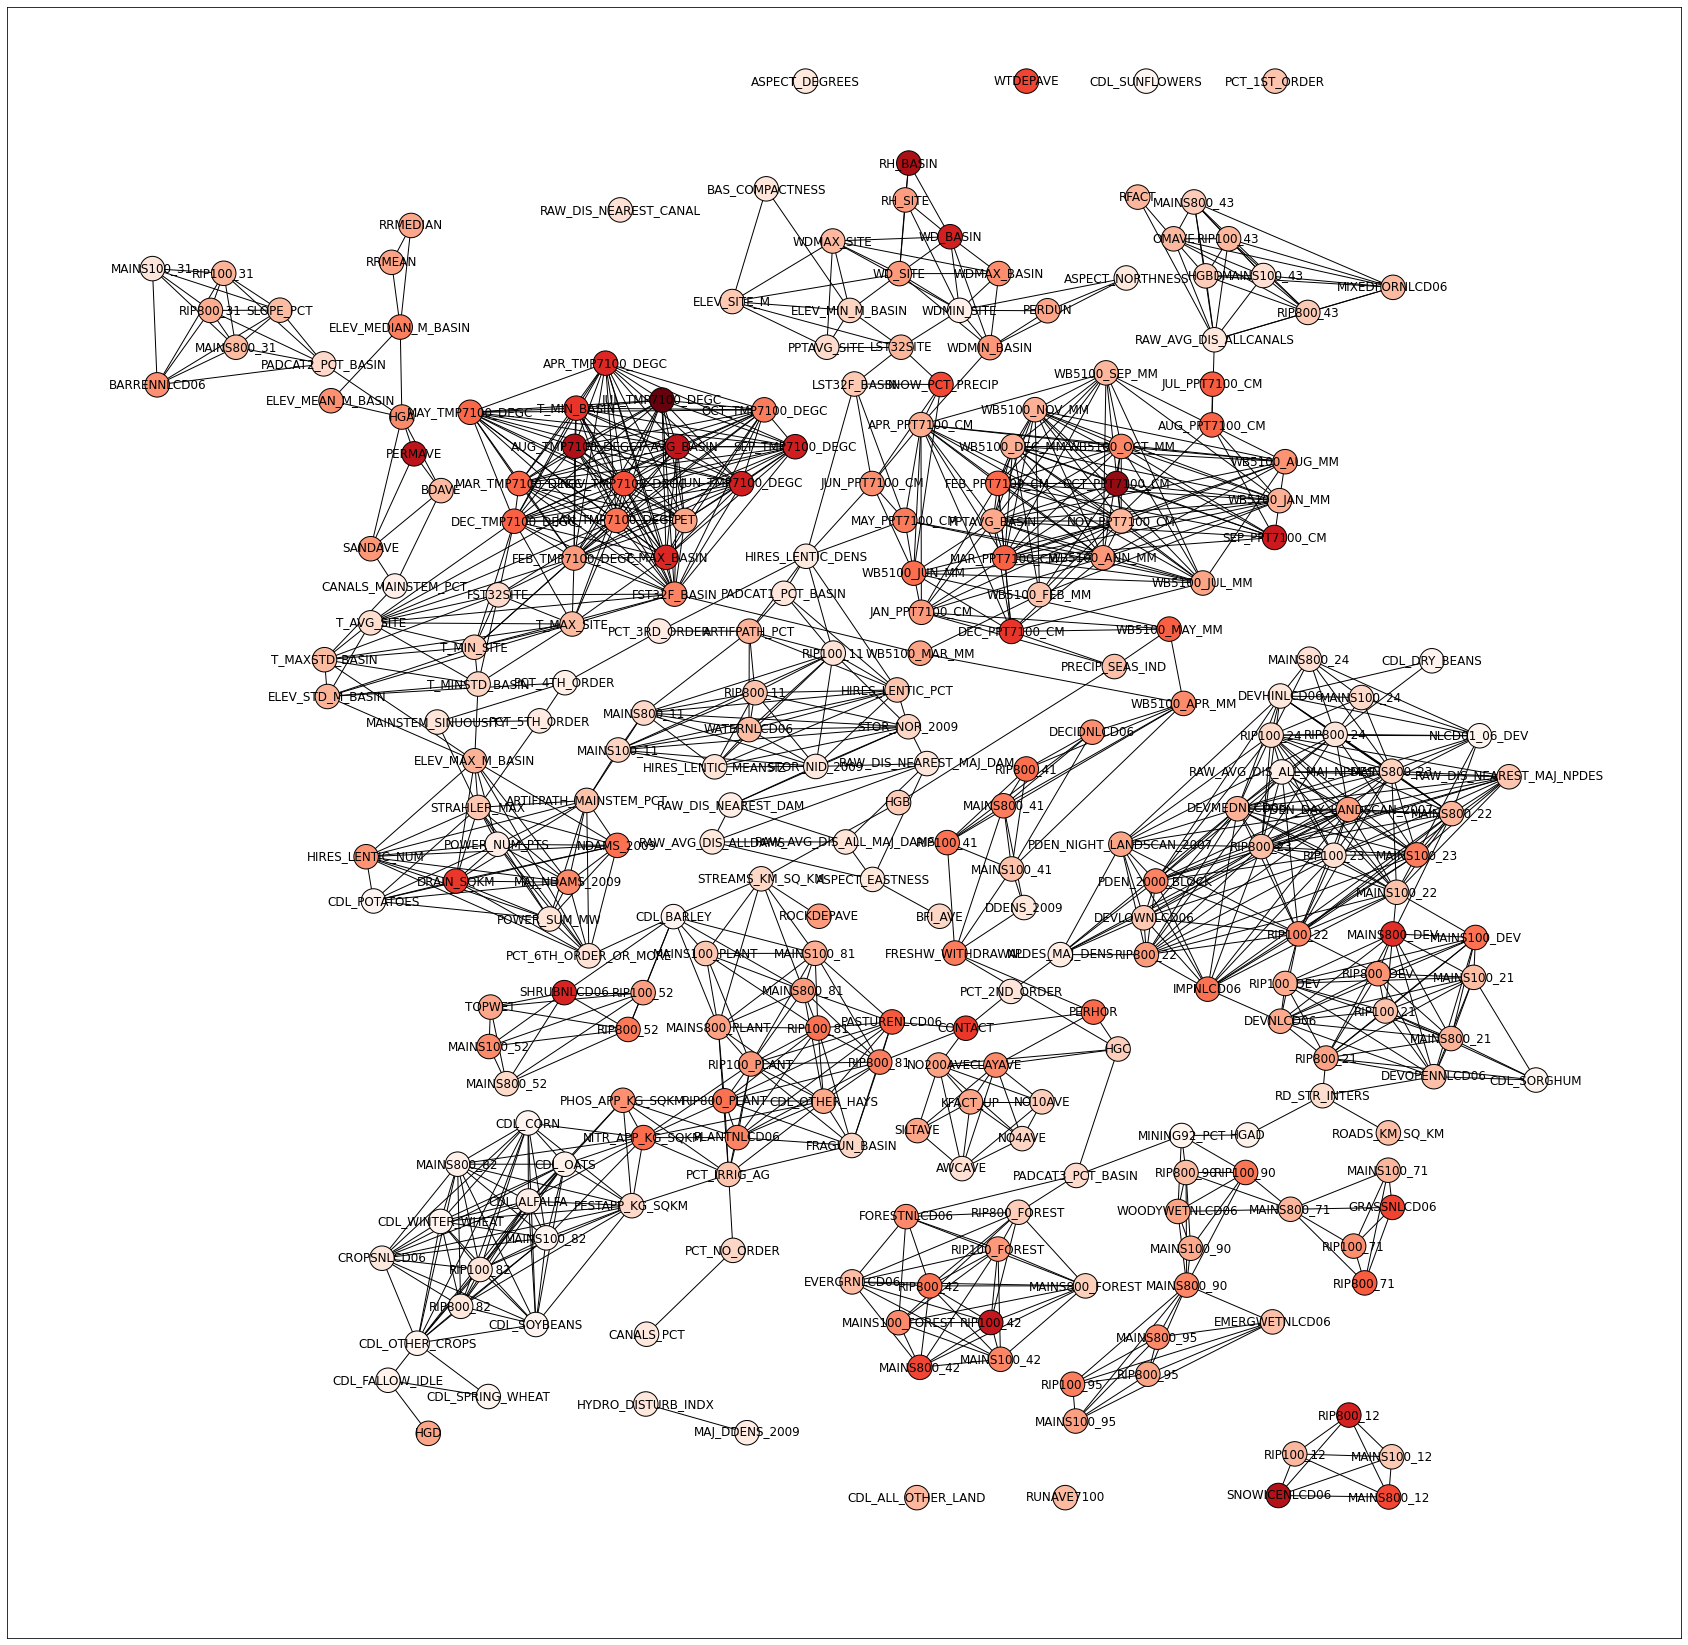

In [19]:
    nodes_id_giant_comp = list(sorted(nx.connected_components(G), key=len, reverse=True)[0])
    print(len(nodes_id_giant_comp))
    df_giant_comp = df.iloc[nodes_id_giant_comp, :]
    print(len(df_giant_comp))
    
    feature_importance = dict(enumerate(get_features_importance_from_forest(M[nodes_id_giant_comp, :], df_giant_comp["community"].values)))
    importance_sorted_attributes = [b[0] for b in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)]
    importance_sorted_attributes_cols = [cols_for_similarity[x] for x in importance_sorted_attributes]
    print(importance_sorted_attributes_cols)
    
    quantities = [{"name": "feature_importance", "values":feature_importance, "discrete":False}]
    plot_network(G_V, quantities, suffix='attributes')


# Cluster-informed random forest

19
['OCT_PPT7100_CM', 'JUL_TMP7100_DEGC', 'IMPNLCD06', 'PASTURENLCD06', 'RH_BASIN', 'NITR_APP_KG_SQKM', 'MAINS800_DEV', 'DRAIN_SQKM', 'RIP100_42', 'RIP100_95', 'CONTACT', 'MAINS800_41', 'PERMAVE', 'BARRENNLCD06', 'SHRUBNLCD06', 'GRASSNLCD06', 'SNOWICENLCD06', 'HGD', 'WTDEPAVE', 'APR_PPT7100_CM', 'RAW_AVG_DIS_ALLCANALS', 'RIP100_11', 'CLAYAVE', 'ELEV_MEDIAN_M_BASIN', 'T_MAXSTD_BASIN', 'WDMIN_SITE', 'WOODYWETNLCD06', 'STREAMS_KM_SQ_KM'] 28


ValueError: vmin, vcenter, and vmax must be in ascending order

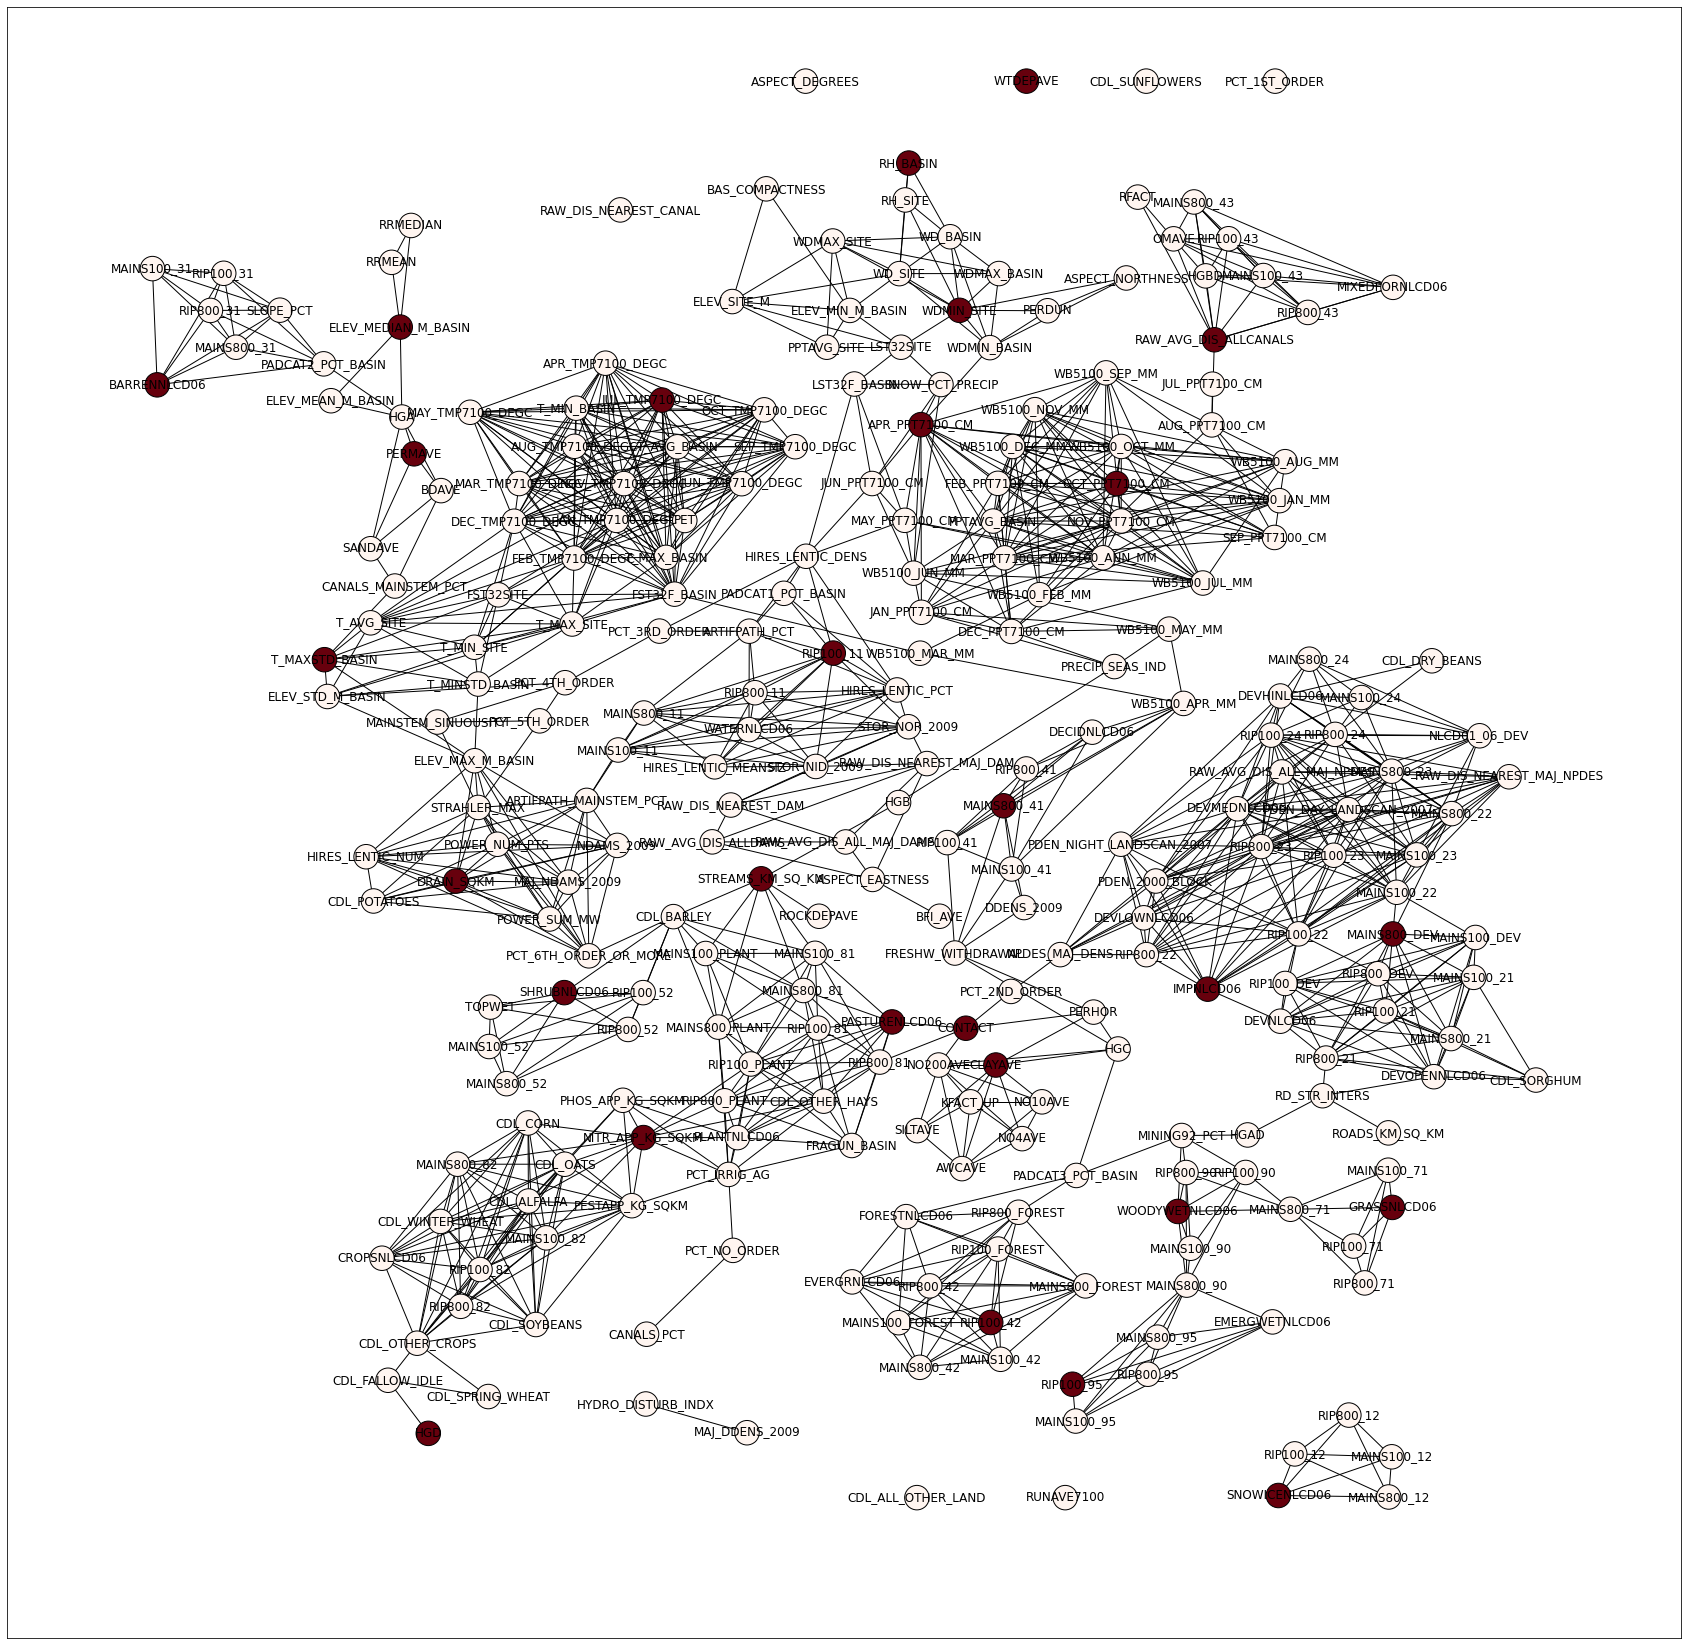

In [20]:
    average_importance_in_network = np.mean(list(feature_importance.values()))
    #importance_clusters = []
    #top_nodes_importance = {}
    cumulative_importance_cluster= []
    importance_coverage_cluster = {x:0. for x in feature_importance.keys()}
    attributes_list = []
    for community, nodes_in_community in communities_attr_to_nodes_dict.items():
        dict_importance_nodes_in_community = {x:y for x,y in feature_importance.items() if x in nodes_in_community}
        top_importance_value_in_community = np.max(list(dict_importance_nodes_in_community.values()))
        if top_importance_value_in_community<average_importance_in_network:continue
        node_candidates = [x for x,y in dict_importance_nodes_in_community.items() if y>=0.9*top_importance_value_in_community]
        #top_degree_high_importance = sorted({x:y for x,y in attr_degrees.items() if x in node_candidates}.items(), key=lambda item: item[1], reverse=True)[0][0]
        top_degree_high_importance = sorted({x:feature_importance[x]+np.sum([feature_importance[y] for y in G_V.neighbors(x)]) for  x in node_candidates}.items(), key=lambda item: item[1], reverse=True)[0][0]
        importance_coverage_cluster[top_degree_high_importance]=np.max([1., importance_coverage_cluster[top_degree_high_importance]])
        for i in G_V.neighbors(top_degree_high_importance):
            importance_coverage_cluster[i] = np.max([0.00001, importance_coverage_cluster[i]])
        attributes_list.append(cols_for_similarity[top_degree_high_importance])
        cumulative_importance_cluster.append(np.sum([y for x,y in feature_importance.items() if importance_coverage_cluster[x]!=0]))
        #top_importance_node_in_community = sorted({x:y for x,y in feature_importance.items() if x in nodes_in_community}.items(), key=lambda item: item[1], reverse=True)[0][0]
        #top_nodes_importance[top_importance_node_in_community] = np.sum([feature_importance[i] for i in nodes_in_community])
    #for chosen_node,_ in sorted(top_nodes_importance.items(), key=lambda item: item[1], reverse=True):
    #    importance_clusters.append(top_nodes_importance[chosen_node])
    #    print(cols_for_similarity[chosen_node], np.sum(importance_clusters))
    #    attributes_list.append(cols_for_similarity[chosen_node])
    print(len(attributes_list))
    while cumulative_importance_cluster[-1]<0.9:
        not_seen_yet = [x for x,y in importance_coverage_cluster.items() if y==0]
        scores_not_seen_yet = {}
        for node in not_seen_yet:
            neighs_not_seen_yet = list(set(list(G_V.neighbors(node))).intersection(not_seen_yet))
            scores_not_seen_yet[node] = np.sum([feature_importance[x] for x in [node]+neighs_not_seen_yet])
        top_choice = sorted(scores_not_seen_yet.items(), key=lambda item: item[1], reverse=True)[0][0]
        importance_coverage_cluster[top_choice]=np.max([1., importance_coverage_cluster[top_choice]])
        for i in G_V.neighbors(top_choice):
            importance_coverage_cluster[i] = np.max([0.00001, importance_coverage_cluster[i]])
        attributes_list.append(cols_for_similarity[top_choice])
        cumulative_importance_cluster.append(np.sum([y for x,y in feature_importance.items() if importance_coverage_cluster[x]!=0]))


    print(attributes_list, len(attributes_list))

    quantities = [{"name": "feature_importance_cluster_informed", "values":importance_coverage_cluster, "discrete":False}]
    plot_network(G_V, quantities, suffix='attributes')


# Random forest only

['JUL_TMP7100_DEGC', 'OCT_PPT7100_CM', 'RH_BASIN', 'AUG_TMP7100_DEGC', 'SNOWICENLCD06', 'PERMAVE', 'T_AVG_BASIN', 'RIP100_42', 'SEP_PPT7100_CM', 'SEP_TMP7100_DEGC', 'JUN_TMP7100_DEGC', 'WD_BASIN', 'RIP800_12', 'SHRUBNLCD06', 'T_MAX_BASIN', 'APR_TMP7100_DEGC', 'MAINS800_DEV', 'T_MIN_BASIN', 'DEC_PPT7100_CM', 'DRAIN_SQKM', 'CONTACT', 'GRASSNLCD06', 'MAINS800_42', 'WTDEPAVE', 'MAINS800_12', 'SNOW_PCT_PRECIP', 'NOV_TMP7100_DEGC', 'PASTURENLCD06'] 28


ValueError: vmin, vcenter, and vmax must be in ascending order

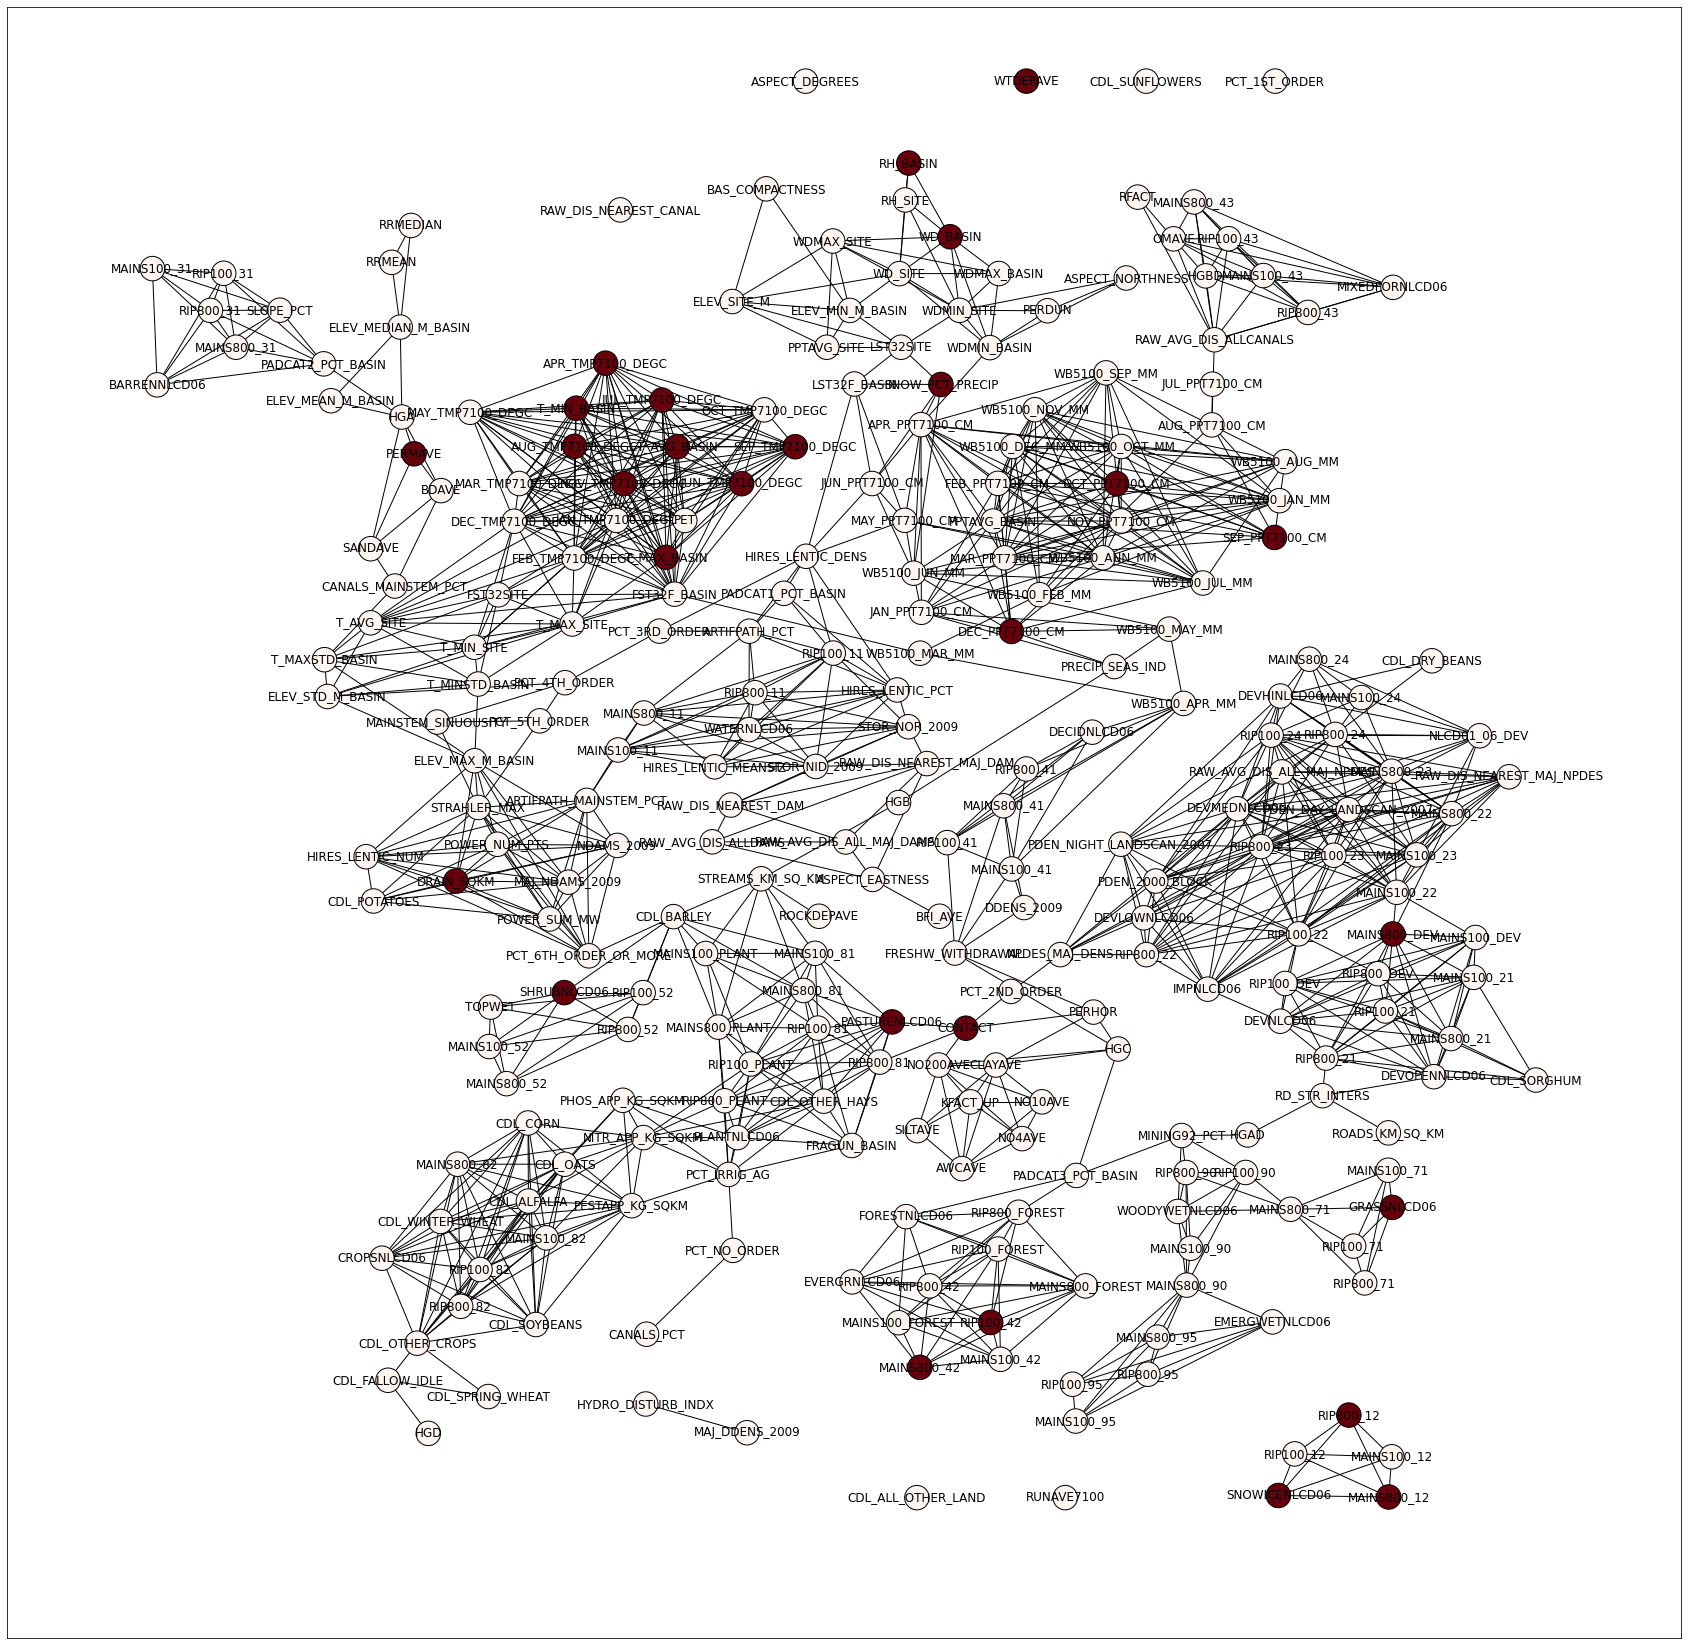

In [21]:

    importance_sorted_attributes_top_n = importance_sorted_attributes[:len(attributes_list)]
    importance_sorted_attributes_top_n_col = [cols_for_similarity[x] for x in importance_sorted_attributes_top_n]
    print(importance_sorted_attributes_top_n_col, len(importance_sorted_attributes_top_n_col))

    importance_coverage_no_cluster = {x:0. for x in feature_importance.keys()}
    cumulative_importance_no_cluster = []
    for i in importance_sorted_attributes_top_n:
        importance_coverage_no_cluster[i] = np.max([1., importance_coverage_no_cluster[i]])
        for j in G_V.neighbors(i):
            importance_coverage_no_cluster[j] = np.max([.00001, importance_coverage_no_cluster[j]])
        cumulative_importance_no_cluster.append(np.sum([y for x,y in feature_importance.items() if importance_coverage_no_cluster[x]!=0]))

    quantities = [{"name": "feature_importance_random_forest_only", "values":importance_coverage_no_cluster, "discrete":False}]
    plot_network(G_V, quantities, suffix='attributes')

# Load and merge hydrological indices

In [ ]:
df_WQ = pd.read_csv("RDC_hydrological_signatures_1971_2000_olden.csv", sep=",", encoding = "utf-8", encoding_errors='replace', dtype={"STAID":"str"})
df_WQ.replace([np.inf, -np.inf], np.nan,inplace=True)
df_WQ = pd.merge(df[['STAID', 'community']], df_WQ, on="STAID")
df_WQ["community_size"] = pd.Series([community_counts_dict[x] for x in df_WQ["community"].values])


# Plot cluster aggregated hydrological indices

In [ ]:
plot_WQ(df_WQ)